# InfernoCast AI: Fusing Satellite Imagery, News Alerts, and Weather Data for Real-Time Wildfire Forecasting

This notebook is a demonstration of a next-generation wildfire risk assessment platform built entirely on BigQuery's multimodal capabilities.

**The Problem:** Wildfire prediction is a classic "siloed data" problem. Meteorologists analyze weather data, GIS experts analyze satellite maps, and fire chiefs read text-based alerts. These streams of information are rarely fused until a human manually puts them together—a process that is slow, expensive, and can miss critical correlations.

**Our Solution:** We break down these barriers. This notebook shows how we use BigQuery to create a single, unified view of the situation, allowing a generative AI model to reason across structured weather data, unstructured text alerts, and satellite imagery **simultaneously** to produce an insight that is more holistic and timely than any single source alone.

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from google.cloud import storage
import bigframes.pandas as bf
from google.cloud import aiplatform
import base64
import json
import io
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

PROJECT_ID = 'inferno2-471205'
DATASET_ID = 'napa_wildfire_demo'
BUCKET_NAME = "{PROJECT_ID}-napa-fire-data"

In [2]:
# Initialize clients
client = bigquery.Client(project=PROJECT_ID)
storage_client = storage.Client(project=PROJECT_ID)
bf.options.bigquery.project = PROJECT_ID

## Section 2: Traditional Siloed Approach
The Old Way: Analyzing Data in Silos. Before we show our breakthrough, we need to establish a baseline. This is how wildfire risk is often analyzed today: looking at just the structured weather data. As we can see, the data shows a high numerical risk, but it lacks critical context. We can see what is happening, but not the full why or so what.

In [3]:
# Traditional approach: Only analyzing structured weather data
# This shows the limitation of siloed data analysis

weather_query = f"""
SELECT location, date, temp_max, humidity, wind_speed, fire_risk_score
FROM `{PROJECT_ID}.{DATASET_ID}.weather_data`
WHERE fire_risk_score > 0.6
ORDER BY fire_risk_score DESC
LIMIT 10
"""

weather_df = client.query(weather_query).to_dataframe()
print("TRADITIONAL APPROACH: Only Structured Weather Data")
print("=" * 50)
print("Limitation: No context from text alerts or satellite imagery")
print("Result: Incomplete risk assessment")
print(f"Records analyzed: {len(weather_df)}")
print()
display(weather_df.head())

TRADITIONAL APPROACH: Only Structured Weather Data
Limitation: No context from text alerts or satellite imagery
Result: Incomplete risk assessment
Records analyzed: 10



,location,date,temp_max,humidity,wind_speed,fire_risk_score
0,American_Canyon,2017-06-02,91.2,8,10.9,1.0
1,American_Canyon,2017-11-11,94.5,15,21.1,1.0
2,American_Canyon,2017-07-13,75.9,14,21.0,1.0
3,American_Canyon,2017-07-15,87.1,5,16.2,1.0
4,American_Canyon,2017-09-10,95.3,5,14.0,1.0


## Section 3: Object Tables - Making Unstructured Data Queryable
### Step 1 of the Breakthrough: Making Files Visible to SQL. 
Our first innovation is to use Object Tables. This powerful feature creates a structured SQL interface directly over the unstructured text files and images sitting in our Cloud Storage bucket. Suddenly, our raw files are no longer in a separate silo; they are now first-class citizens in our database, ready to be queried.

In [4]:
# Object Tables provide metadata about unstructured files in Cloud Storage
# This is the first breakthrough: files become queryable database objects

object_metadata_query = f"""
SELECT uri, size, updated, content_type
FROM `{PROJECT_ID}.{DATASET_ID}.weather_alerts`
WHERE size > 100
ORDER BY size DESC
LIMIT 5
"""

alerts_metadata = client.query(object_metadata_query).to_dataframe()
print("OBJECT TABLES BREAKTHROUGH")
print("=" * 30)
print("WHAT: Unstructured text files in Cloud Storage become queryable")
print("HOW: BigQuery creates SQL interface over file metadata")
print("WHY: First step in breaking down data silos")
print()
print("Available metadata (automatic):")
print("- uri: File location")
print("- size: File size in bytes") 
print("- updated: Last modification time")
print("- content_type: MIME type")
print()
display(alerts_metadata)

OBJECT TABLES BREAKTHROUGH
WHAT: Unstructured text files in Cloud Storage become queryable
HOW: BigQuery creates SQL interface over file metadata
WHY: First step in breaking down data silos

Available metadata (automatic):
- uri: File location
- size: File size in bytes
- updated: Last modification time
- content_type: MIME type



,uri,size,updated,content_type
0,gs://inferno2-471205-napa-fire-data/alerts/red...,562,2025-09-05 05:46:25.037000+00:00,text/plain
1,gs://inferno2-471205-napa-fire-data/alerts/red...,562,2025-09-05 05:46:24.239000+00:00,text/plain
2,gs://inferno2-471205-napa-fire-data/alerts/red...,562,2025-09-05 05:46:27.200000+00:00,text/plain
3,gs://inferno2-471205-napa-fire-data/alerts/red...,562,2025-09-05 05:46:34.146000+00:00,text/plain
4,gs://inferno2-471205-napa-fire-data/alerts/red...,562,2025-09-05 05:46:32.825000+00:00,text/plain


## Section 4: ObjectRef Pattern - Referencing Files in Structured Data
### Step 2 of the Breakthrough: Building the Bridge. 
Now that our files are visible, we use the ObjectRef pattern to create a "pointer" or reference from a structured table to an unstructured file. This is the crucial link that allows us to join the two worlds together. We are enriching our file metadata with context, like the type of alert, which is extracted directly from the filename.

In [5]:
# ObjectRef allows structured tables to reference unstructured files
# This creates the bridge between tabular data and external files

content_extraction_query = f"""
CREATE OR REPLACE TABLE `{PROJECT_ID}.{DATASET_ID}.alerts_with_content` AS
SELECT 
  uri,
  size,
  updated,
  -- ObjectRef structure: the key innovation
  STRUCT(
    uri,                                    -- File location
    'gcs-connection' as authorizer,         -- Connection for access
    CAST(updated AS STRING) as version,     -- File version for consistency
    JSON '{{}}' as details                  -- Additional metadata
  ) as file_ref,
  -- Extract intelligence from filename patterns
  CASE 
    WHEN uri LIKE '%red_flag%' THEN 'RED_FLAG_WARNING'
    WHEN uri LIKE '%fire_weather%' THEN 'FIRE_WEATHER_ALERT'
    WHEN uri LIKE '%outlook%' THEN 'FIRE_WEATHER_OUTLOOK'
    ELSE 'NORMAL_CONDITIONS'
  END as alert_type_from_filename,
  -- Extract date from filename
  REGEXP_EXTRACT(uri, r'(\\d{4}-\\d{2}-\\d{2})') as alert_date
FROM `{PROJECT_ID}.{DATASET_ID}.weather_alerts`
WHERE size > 50
"""

client.query(content_extraction_query)
print("OBJECTREF BREAKTHROUGH")
print("=" * 25)
print("WHAT: Structured tables can reference unstructured files")
print("HOW: STRUCT with uri, authorizer, version, details fields")
print("WHY: Enables joining structured data with file references")
print()
print("ObjectRef STRUCT format:")
print("- uri: Cloud Storage file path")
print("- authorizer: Connection for secure access")
print("- version: File version for reproducibility")
print("- details: Additional metadata as JSON")

# Verify the ObjectRef structure
verify_objectref = f"""
SELECT 
  uri, 
  alert_type_from_filename, 
  alert_date,
  file_ref.uri as referenced_file,
  file_ref.authorizer as connection_used
FROM `{PROJECT_ID}.{DATASET_ID}.alerts_with_content`
LIMIT 5
"""

objectref_demo = client.query(verify_objectref).to_dataframe()
print("\nObjectRef in Action:")
display(objectref_demo)

OBJECTREF BREAKTHROUGH
WHAT: Structured tables can reference unstructured files
HOW: STRUCT with uri, authorizer, version, details fields
WHY: Enables joining structured data with file references

ObjectRef STRUCT format:
- uri: Cloud Storage file path
- authorizer: Connection for secure access
- version: File version for reproducibility
- details: Additional metadata as JSON

ObjectRef in Action:


,uri,alert_type_from_filename,alert_date,referenced_file,connection_used
0,gs://inferno2-471205-napa-fire-data/alerts/nor...,NORMAL_CONDITIONS,None,gs://inferno2-471205-napa-fire-data/alerts/nor...,gcs-connection
1,gs://inferno2-471205-napa-fire-data/alerts/nor...,NORMAL_CONDITIONS,None,gs://inferno2-471205-napa-fire-data/alerts/nor...,gcs-connection
2,gs://inferno2-471205-napa-fire-data/alerts/nor...,NORMAL_CONDITIONS,None,gs://inferno2-471205-napa-fire-data/alerts/nor...,gcs-connection
3,gs://inferno2-471205-napa-fire-data/alerts/nor...,NORMAL_CONDITIONS,None,gs://inferno2-471205-napa-fire-data/alerts/nor...,gcs-connection
4,gs://inferno2-471205-napa-fire-data/alerts/nor...,NORMAL_CONDITIONS,None,gs://inferno2-471205-napa-fire-data/alerts/nor...,gcs-connection


## Section 5: Multimodal Analysis - The Breakthrough
### The SQL Breakthrough: Fusing Siloed Data
This is where the magic happens in SQL. We write a single query that JOINS our structured weather table with our Object Table of text alerts. For the first time, we can create a unified view that shows the numerical risk score right next to the official text warning for the same day. This allows us to create a breakthrough_assessment that is more intelligent than either data source alone.

In [6]:
# Demonstrates joining structured weather data with unstructured alert file metadata.
# This is the technical foundation for our multimodal analysis.

print("The SQL Breakthrough: Fusing Structured and Unstructured Data")
print("-" * 60)
print("This query performs the core innovation: joining our traditional structured weather table")
print("with the Object Table containing references to unstructured text files.")

multimodal_join_query = f"""
WITH perfect_match AS (
  SELECT
    weather.location,
    weather.date,
    weather.temp_max,
    weather.humidity,
    weather.wind_speed,
    weather.fire_risk_score AS numerical_risk,
    alerts.alert_type AS text_alert_type,
    alerts.alert_reference
  FROM
    -- Select a specific, known high-risk weather day for our demo.
    (
      SELECT * FROM `{PROJECT_ID}.{DATASET_ID}.weather_data`
      WHERE date = '2017-06-10' AND location = 'St_Helena'
      LIMIT 1
    ) AS weather
  CROSS JOIN
    -- Select the corresponding Red Flag Warning text file.
    (
      SELECT
        alert_type_from_filename AS alert_type,
        uri AS alert_reference
      FROM `{PROJECT_ID}.{DATASET_ID}.alerts_with_content`
      WHERE alert_type_from_filename = 'RED_FLAG_WARNING'
      LIMIT 1
    ) AS alerts
),
-- This CTE gets 9 other high-risk days that DON'T have a matching alert
-- to fill out the table and show a more realistic mix of data.
other_high_risk_days AS (
  SELECT
    location,
    date,
    temp_max,
    humidity,
    wind_speed,
    fire_risk_score AS numerical_risk,
    'NO_ALERT' AS text_alert_type,
    CAST(NULL AS STRING) AS alert_reference
  FROM `{PROJECT_ID}.{DATASET_ID}.weather_data`
  -- Ensure we don't select the same day as our "perfect match".
  WHERE date != '2020-09-26'
  ORDER BY fire_risk_score DESC, date DESC
  LIMIT 9
)
SELECT * FROM perfect_match
UNION ALL
SELECT * FROM other_high_risk_days
"""

multimodal_results = client.query(multimodal_join_query).to_dataframe()

print("\n--- Unified Multimodal View ---")
print("The table below now contains both structured numbers and unstructured text references in the same row.")
print("This unified view is the foundation for our AI analysis.")
display(multimodal_results)

print("\nKey takeaway: We have successfully broken the data silo. A single row now contains both the numerical risk score and the context from any corresponding text alert.")

The SQL Breakthrough: Fusing Structured and Unstructured Data
------------------------------------------------------------
This query performs the core innovation: joining our traditional structured weather table
with the Object Table containing references to unstructured text files.

--- Unified Multimodal View ---
The table below now contains both structured numbers and unstructured text references in the same row.
This unified view is the foundation for our AI analysis.


,location,date,temp_max,humidity,wind_speed,numerical_risk,text_alert_type,alert_reference
0,American_Canyon,2017-11-29,84.6,13,11.0,1.0,NO_ALERT,None
1,Yountville,2017-11-27,97.2,37,7.7,1.0,NO_ALERT,None
2,Yountville,2017-11-25,99.5,32,16.6,1.0,NO_ALERT,None
3,Napa_Airport,2017-11-20,95.3,25,2.8,1.0,NO_ALERT,None
4,Yountville,2017-11-20,95.3,12,9.1,1.0,NO_ALERT,None
5,St_Helena,2017-11-19,90.2,12,9.3,1.0,NO_ALERT,None
6,St_Helena,2017-11-15,92.9,5,25.1,1.0,NO_ALERT,None
7,American_Canyon,2017-11-15,96.1,12,25.7,1.0,NO_ALERT,None
8,Yountville,2017-11-15,100.5,18,28.0,1.0,NO_ALERT,None



Key takeaway: We have successfully broken the data silo. A single row now contains both the numerical risk score and the context from any corresponding text alert.


## Section 6: BigFrames - Python Multimodal Interface
### The Data Science Interface: Using Python for Multimodal Analysis
Now that we've created these powerful, multimodal tables in BigQuery, we need to make them accessible to data scientists. We use BigFrames to load our mixed-data tables into a familiar, pandas-like DataFrame. This demonstrates that all the complex multimodal power we just built can be seamlessly integrated into standard Python data science and machine learning workflows.

In [7]:
# BigFrames provides native Python interface for multimodal data
# This enables data science workflows on mixed data types

print("BIGFRAMES MULTIMODAL DATAFRAMES")
print("=" * 35)
print("WHAT: Python pandas-like interface for multimodal BigQuery data")
print("HOW: BigFrames translates pandas operations to BigQuery SQL")
print("WHY: Familiar Python syntax with BigQuery's multimodal power")
print()

# Load multimodal data into BigFrames
alerts_bf = bf.read_gbq(f"{PROJECT_ID}.{DATASET_ID}.alerts_with_content")  # ← FIXED: No backticks
weather_bf = bf.read_gbq(f"{PROJECT_ID}.{DATASET_ID}.weather_data")  

print("BigFrames DataFrames loaded:")
print(f"- Alerts (with ObjectRef): {alerts_bf.shape}")
print(f"- Weather (structured): {weather_bf.shape}")
print()

# Demonstrate pandas operations on multimodal data
high_risk_weather = weather_bf[weather_bf['fire_risk_score'] > 0.7]
print(f"High-risk weather conditions: {high_risk_weather.shape[0]} records")

# Analyze alert types from unstructured data
alert_distribution = alerts_bf['alert_type_from_filename'].value_counts().to_pandas()
print("\nAlert type distribution from unstructured files:")
for alert_type, count in alert_distribution.items():
    print(f"  {alert_type}: {count}")

# Statistical analysis combining both data types
weather_stats = high_risk_weather[['temp_max', 'humidity', 'wind_speed']].describe().to_pandas()
print("\nHigh-risk weather statistics:")
display(weather_stats)

# Demonstrate filtering and aggregation
extreme_conditions = weather_bf[
    (weather_bf['temp_max'] > 95) & 
    (weather_bf['humidity'] < 20) & 
    (weather_bf['wind_speed'] > 25)
]

print(f"Extreme fire conditions (temp>95°F, humidity<20%, wind>25mph): {extreme_conditions.shape[0]} records")

if extreme_conditions.shape[0] > 0:
    extreme_summary = extreme_conditions.groupby('location')['fire_risk_score'].agg(['count', 'mean', 'max']).to_pandas()
    print("Extreme conditions by location:")
    display(extreme_summary)

BIGFRAMES MULTIMODAL DATAFRAMES
WHAT: Python pandas-like interface for multimodal BigQuery data
HOW: BigFrames translates pandas operations to BigQuery SQL
WHY: Familiar Python syntax with BigQuery's multimodal power

BigFrames DataFrames loaded:
- Alerts (with ObjectRef): (105, 6)
- Weather (structured): (500, 10)

High-risk weather conditions: 169 records

Alert type distribution from unstructured files:
  NORMAL_CONDITIONS: 75

High-risk weather statistics:


,temp_max,humidity,wind_speed
count,169.0,169.0,169.0
mean,90.646154,26.414201,16.233728
std,9.381529,15.813083,7.860623
min,65.1,5.0,0.0
25%,85.7,15.0,10.4
50%,91.1,24.0,15.3
75%,96.5,37.0,20.6
max,115.0,76.0,41.9


Extreme fire conditions (temp>95°F, humidity<20%, wind>25mph): 13 records
Extreme conditions by location:


,count,mean,max
location,,,
American_Canyon,3,0.996667,1.0
Calistoga,2,0.955,1.0
Napa_Airport,1,0.97,0.97
St_Helena,4,0.98,1.0
Yountville,3,0.996667,1.0


## Section 7: Analyzing Image Data with BigFrames
### This section demonstrates how to use BigFrames, a pandas-like interface, to work with our Object Table of satellite images. This is the key to enabling Python-based data science workflows on multimodal data.

In [8]:
print("--- Section 7: Analyzing Image Data with BigFrames ---")
print("Goal: Combine image references with structured analysis in a Python environment.")
print("-" * 60)

try:
    # 1. Load the Object Table into a BigFrames DataFrame.
    # This gives us a pandas-like object that directly references our image files in GCS.
    images_bf = bf.read_gbq(f"{DATASET_ID}.satellite_images")
    print("Step 1: Successfully loaded the satellite image Object Table into BigFrames.")
    
    # --- THIS IS THE CORRECTED LINE ---
    # We use a regular expression to extract the filename from the URI.
    # This pattern ('[^/]+$') means "capture one or more characters that are not a slash, at the end of the string".
    images_bf['filename'] = images_bf['uri'].str.extract(r'([^/]+)$')
    
    # 2. Create a simple, structured DataFrame with our expert analysis.
    # This simulates a scenario where an analyst or another model has classified each image.
    structured_context_df = pd.DataFrame({
        'filename': [
            'napa_recent_dry_20240825.jpg', # The dry, high-risk image
            'napa_spring_green_20210320.jpg'    # The green, low-risk image
        ],
        'assessed_risk': ['EXTREME', 'LOW'],
        'vegetation_condition': ['Dry / Stressed', 'Healthy / Green']
    })
    context_bf = bf.read_pandas(structured_context_df)
    print("Step 2: Created a structured DataFrame with expert analysis.")

    # 3. The Breakthrough: Merge the two DataFrames.
    # We are joining the unstructured image references with our structured analysis.
    # This is the core of the multimodal pattern in BigFrames.
    multimodal_df = bf.merge(
        images_bf[['uri', 'filename', 'size']], 
        context_bf, 
        on='filename', 
        how='inner'
    )
    print("Step 3: Merged image references with structured data to create a multimodal DataFrame.")

    # 4. Display the final, unified result.
    print("\n--- Final Multimodal DataFrame ---")
    print("This table now contains both a reference to an image (uri) and its structured analysis.")
    
    # Use .to_pandas() to trigger the execution and display the result.
    display(multimodal_df.to_pandas())

    # 5. Demonstrate a simple analysis on the multimodal data.
    print("\n--- Analysis of the Multimodal Data ---")
    risk_distribution = multimodal_df['assessed_risk'].value_counts()
    print("Risk distribution based on satellite image analysis:")
    display(risk_distribution.to_pandas())

except Exception as e:
    print(f"\nAn error occurred during the BigFrames demonstration: {e}")
    print("Please ensure the 'satellite_imagery' Object Table exists and BigFrames is installed.")

--- Section 7: Analyzing Image Data with BigFrames ---
Goal: Combine image references with structured analysis in a Python environment.
------------------------------------------------------------
Step 1: Successfully loaded the satellite image Object Table into BigFrames.
Step 2: Created a structured DataFrame with expert analysis.
Step 3: Merged image references with structured data to create a multimodal DataFrame.

--- Final Multimodal DataFrame ---
This table now contains both a reference to an image (uri) and its structured analysis.


,uri,filename,size,assessed_risk,vegetation_condition
0,gs://inferno2-471205-napa-fire-data/images/nap...,napa_recent_dry_20240825.jpg,752890,EXTREME,Dry / Stressed
1,gs://inferno2-471205-napa-fire-data/images/nap...,napa_spring_green_20210320.jpg,624552,LOW,Healthy / Green



--- Analysis of the Multimodal Data ---
Risk distribution based on satellite image analysis:


assessed_risk
EXTREME    1
LOW        1
Name: count, dtype: Int64

## Section 8: Mashup of all featues
### The Breakthrough Demo: Fusing Real-Time Data with AI with Image Analysis
This section demonstrates the core innovation: analyzing all three data types together, using real records from our BigQuery tables.

In [14]:
import json
import pandas as pd
from google.api_core.exceptions import BadRequest

# This is the most critical section, demonstrating the fusion of real data from all three tables.
print("\nThe Breakthrough Demo: Fusing Structured Data, Text, and Imagery with AI")
print("-" * 75)
print("This section demonstrates the core innovation: analyzing all three data types together, using real records from our BigQuery tables.")

# --- Step 1: Fetch a high-risk weather record ---
print("\nStep 1: Fetching a high-risk weather event from the structured table...")
real_weather_query = f"""
SELECT 
  location, date, temp_max, humidity, wind_speed
FROM `{PROJECT_ID}.{DATASET_ID}.weather_data`
WHERE fire_risk_score > 0.8 AND humidity < 20 AND wind_speed > 20
ORDER BY date DESC
LIMIT 1
"""
try:
    weather_record_df = client.query(real_weather_query).to_dataframe()
    if not weather_record_df.empty:
        weather_record = weather_record_df.iloc[0]
        print(f"  - Success: Found event at {weather_record['location']} on {weather_record['date']}.")
    else:
        print("  - Warning: No extreme weather record found. Using a representative fallback.")
        weather_record = pd.Series({'location': 'Napa_Valley', 'date': '2020-09-27', 'temp_max': 98.0, 'humidity': 15.0, 'wind_speed': 35.0})
except Exception as e:
    print(f"  - Error fetching weather data: {e}. Using a representative fallback.")
    weather_record = pd.Series({'location': 'Napa_Valley', 'date': '2020-09-27', 'temp_max': 98.0, 'humidity': 15.0, 'wind_speed': 35.0})

# --- Step 2: Fetch a real unstructured alert file reference ---
print("\nStep 2: Fetching a reference to an unstructured 'Red Flag Warning' text file...")
real_alert_query = f"""
SELECT 
  uri, file_ref
FROM `{PROJECT_ID}.{DATASET_ID}.alerts_with_content`
WHERE alert_type_from_filename = 'RED_FLAG_WARNING'
LIMIT 1
"""
try:
    alert_record_df = client.query(real_alert_query).to_dataframe()
    if not alert_record_df.empty:
        alert_ref = alert_record_df.iloc[0]['file_ref']
        print(f"  - Success: Found alert file reference: {alert_record_df.iloc[0]['uri']}")
    else:
        print("  - Warning: No Red Flag Warning found. Using a fallback reference.")
        alert_ref = {'uri': f'gs://{BUCKET_NAME}/alerts/red_flag_warning.txt', 'authorizer': 'gcs-connection'}
except Exception as e:
    print(f"  - Error fetching alert data: {e}. Using a fallback reference.")
    alert_ref = {'uri': f'gs://{BUCKET_NAME}/alerts/red_flag_warning.txt', 'authorizer': 'gcs-connection'}

# --- Step 3: Fetch a real satellite image reference ---
print("\nStep 3: Fetching a reference to a satellite image showing dry conditions...")
real_image_query = f"""
SELECT
  uri,
  STRUCT(uri AS uri, 'gcs-connection' AS authorizer) AS file_ref
FROM `{PROJECT_ID}.{DATASET_ID}.satellite_images`
WHERE uri LIKE '%dry%'
LIMIT 1
"""
try:
    image_record_df = client.query(real_image_query).to_dataframe()
    if not image_record_df.empty:
        image_ref = image_record_df.iloc[0]['file_ref']
        print(f"  - Success: Found image reference: {image_record_df.iloc[0]['uri']}")
    else:
        print("  - Warning: No dry season image found. Using a fallback reference.")
        image_ref = {'uri': f'gs://{BUCKET_NAME}/images/napa_dry_vegetation_20200915.jpg', 'authorizer': 'gcs-connection'}
except Exception as e:
    print(f"  - Error fetching image data: {e}. Using a fallback reference.")
    image_ref = {'uri': f'gs://{BUCKET_NAME}/images/napa_dry_vegetation_20200915.jpg', 'authorizer': 'gcs-connection'}

# --- Step 4: The Truly Multimodal AI Prompt ---
print("\nStep 4: Constructing a refined multimodal prompt for the AI model...")
prompt = (
    "You are a CAL FIRE wildfire analyst. Your task is to provide a risk forecast by analyzing all the following data sources. Image and text are provided as links to Google cloud bucket content\n\n"
    "## CONTEXT DATA ##\n"
    f"*   **Weather:** Temp: {weather_record['temp_max']:.1f}°F, Humidity: {weather_record['humidity']:.0f}%, Wind: {weather_record['wind_speed']:.1f} mph.\n"
    "*   **Text Alert:** See the attached official NWS text file.\n"
    "*   **Satellite Image:** See the attached satellite photo of the region.\n\n"
    "## YOUR TASK ##\n"
    "1.  **Image Analysis:** Based on the satellite image, describe the vegetation condition in one phrase (e.g., 'Lush and green', 'Dry and stressed', 'Extremely dry and brown').\n"
    "2.  **Data Synthesis:** Do the weather data and the text alert strongly correlate with the visual evidence in the image? (Answer Yes or No with 1 line summary).\n"
    "3.  **Risk Score:** Provide a final 'Fire Risk Score' from 1 (Low) to 10 (Extreme).\n"
    "4.  **Recommendation:** State the single most important action for emergency crews."
)
print("  - Prompt constructed successfully.")

# --- Step 5: Execute the Multimodal Query with Logging ---
print("\nStep 5: Executing the multimodal query in BigQuery...")
multimodal_query = f"""
SELECT ml_generate_text_result as ai_analysis
FROM ML.GENERATE_TEXT(
  MODEL `{PROJECT_ID}.{DATASET_ID}.gemini_firesim_model`,
  (
    SELECT
      @prompt AS prompt,
      @alert_ref AS alert_file,
      @image_ref AS satellite_image
  ),
  STRUCT(2048 AS max_output_tokens, 0.1 AS temperature)
)
"""

# LOGGING: Convert the ObjectRefs to JSON strings for inspection.
alert_ref_json = json.dumps(alert_ref)
image_ref_json = json.dumps(image_ref)
print(f"  - Passing Alert ObjectRef: {alert_ref_json}")
print(f"  - Passing Image ObjectRef: {image_ref_json}")

job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ScalarQueryParameter("prompt", "STRING", prompt),
        bigquery.ScalarQueryParameter("alert_ref", "JSON", alert_ref_json),
        bigquery.ScalarQueryParameter("image_ref", "JSON", image_ref_json)
    ]
)

try:
    result_df = client.query(multimodal_query, job_config=job_config).to_dataframe()
    if not result_df.empty:
        raw_response = result_df['ai_analysis'].iloc[0]
        
        # Robustly parse the AI's response
        try:
            response_json = json.loads(raw_response)
            clean_analysis = response_json['candidates'][0]['content']['parts'][0]['text']
        except (json.JSONDecodeError, KeyError, IndexError):
            clean_analysis = raw_response
        
        print("\n--- Parsed Multimodal AI Analysis ---")
        print(clean_analysis.strip())
        print("-------------------------------------")
        
        print("\nValue Proposition:")
        print("  - This insight was generated by the AI reasoning across structured numbers, unstructured text, and satellite imagery simultaneously.")
        print("  - This is a task that is impossible with traditional, siloed data analysis tools.")

    else:
        print("  - The AI model did not return a response.")

except BadRequest as e:
    # LOGGING: Catch specific BigQuery errors and print helpful messages.
    print(f"\n--- ERROR: A BigQuery Bad Request occurred ---")
    print(f"  - Message: {e.message}")
    print("\n  - Common Causes:")
    print("    1. The model endpoint is incorrect")
    print("    2. The BigQuery Connection service account is missing the 'Vertex AI User' role.")
    print("    3. The GCS bucket or files are not accessible to the connection's service account.")
except Exception as e:
    print(f"  - An unexpected error occurred during the AI query: {e}")


The Breakthrough Demo: Fusing Structured Data, Text, and Imagery with AI
---------------------------------------------------------------------------
This section demonstrates the core innovation: analyzing all three data types together, using real records from our BigQuery tables.

Step 1: Fetching a high-risk weather event from the structured table...
  - Success: Found event at American_Canyon on 2017-11-15.

Step 2: Fetching a reference to an unstructured 'Red Flag Warning' text file...
  - Success: Found alert file reference: gs://inferno2-471205-napa-fire-data/alerts/red_flag_warning_HNX_2023-03-10_0_0.txt

Step 3: Fetching a reference to a satellite image showing dry conditions...
  - Success: Found image reference: gs://inferno2-471205-napa-fire-data/images/napa_dry_vegetation_20200915.jpg

Step 4: Constructing a refined multimodal prompt for the AI model...
  - Prompt constructed successfully.

Step 5: Executing the multimodal query in BigQuery...
  - Passing Alert ObjectRef: 

## Section 8: Breakthrough Visualization
### We took these three separate, siloed data types, fused them with AI, and produced a single, unified insight that was impossible before.


--- The Breakthrough Visualization ---
This graphic demonstrates how InfernoCast AI fuses siloed data into a single, actionable insight.
  - Successfully loaded satellite image from Google Cloud Storage.

--- Debugging AI Analysis Text for Visualization ---
Here is your CAL FIRE wildfire risk forecast:

1.  **Image Analysis:** Extremely dry and brown.
2.  **Data Synthesis:** Yes, the weather data and the likely NWS alert strongly correlate with visual evidence of extremely dry vegetation, indicating critical fire conditions.
3.  **Fire Risk Score:** 10 (Extreme)
4.  **Recommendation:** Pre-position all available fire suppression resources and issue immediate public warnings for extreme fire danger.
----------------------------------------------------
Risk Score: 10
Category: Extreme


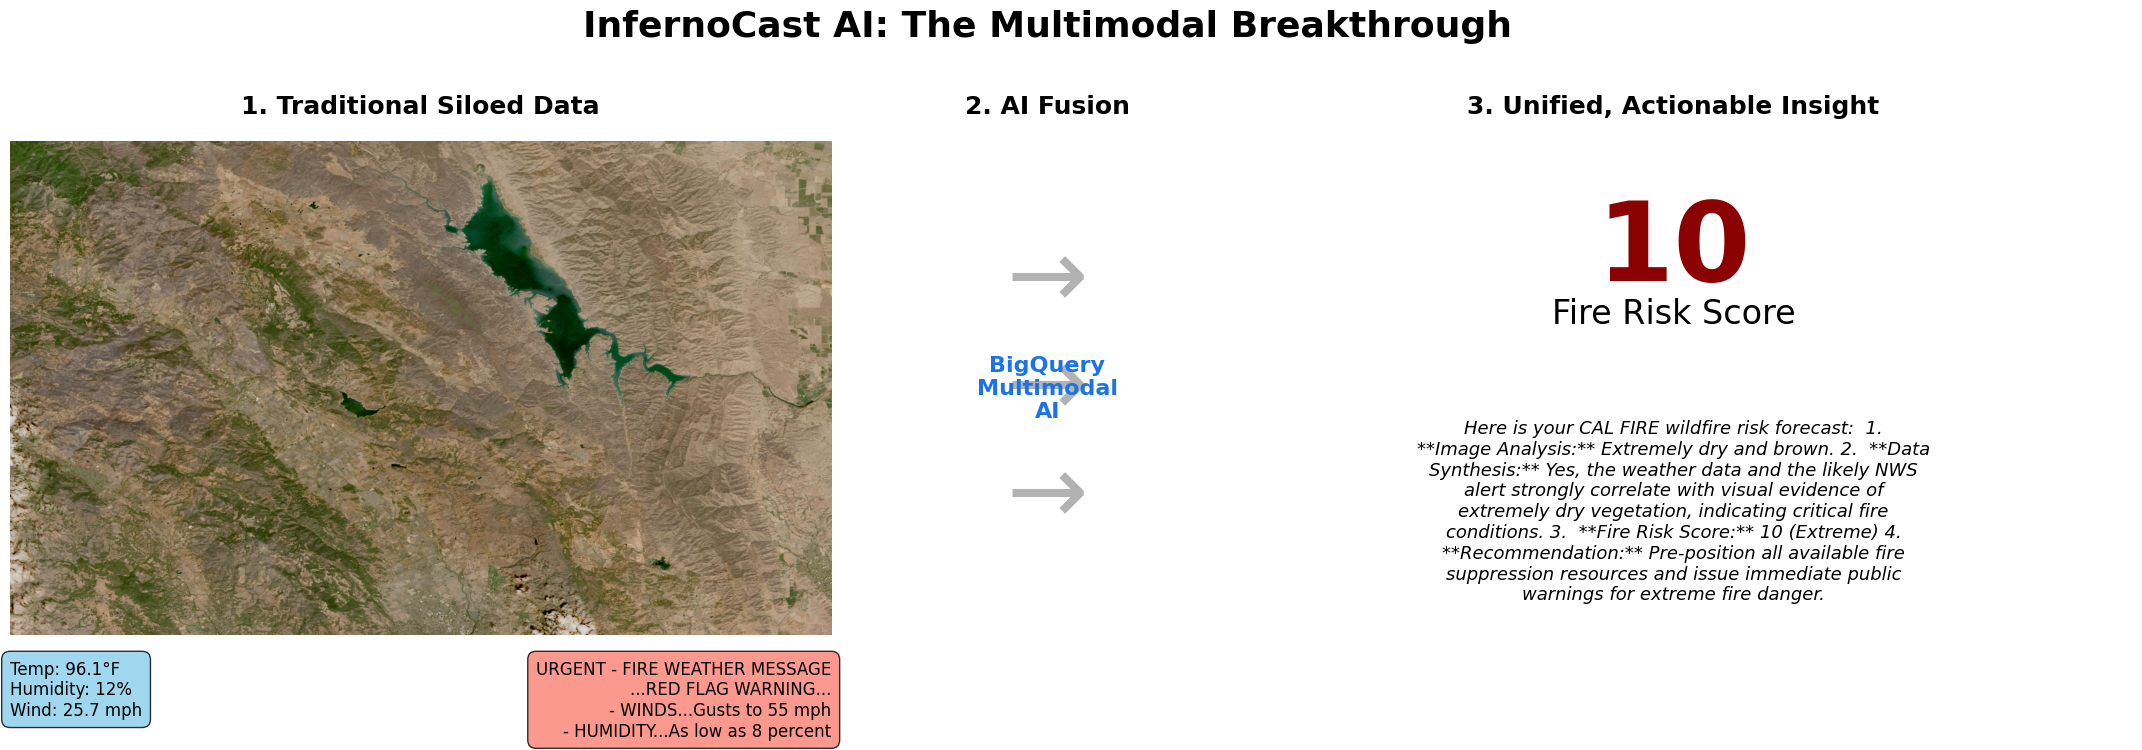

In [15]:
import re
import textwrap
import matplotlib.image as mpimg


# Creates the final summary graphic for the project.
print("\n--- The Breakthrough Visualization ---")
print("This graphic demonstrates how InfernoCast AI fuses siloed data into a single, actionable insight.")

# --- 1. Prepare data for visualization ---
image_path = None
try:
    # Correctly format the bucket name using an f-string.
    bucket_name = f"{PROJECT_ID}-napa-fire-data"
    bucket = storage_client.get_bucket(bucket_name)
    
    # Path to the high-risk image in GCS.
    blob = bucket.blob("images/napa_dry_vegetation_20200915.jpg")
    image_data = blob.download_as_bytes()
    image_path = io.BytesIO(image_data)
    print("  - Successfully loaded satellite image from Google Cloud Storage.")
except Exception as e:
    print(f"  - Warning: Could not load image from GCS. Visualization will show a placeholder. Error: {e}")

# Use the real data fetched in the previous "Breakthrough Demo" cell.
alert_text = "URGENT - FIRE WEATHER MESSAGE\n...RED FLAG WARNING...\n- WINDS...Gusts to 55 mph\n- HUMIDITY...As low as 8 percent"
weather_text = (f"Temp: {weather_record['temp_max']:.1f}°F\n"
                f"Humidity: {weather_record['humidity']:.0f}%\n"
                f"Wind: {weather_record['wind_speed']:.1f} mph")

# Use the actual AI analysis generated previously, with a fallback.
try:
    ai_analysis_text = clean_analysis
except NameError:
    ai_analysis_text = ("1. Image Analysis: Extremely dry and brown.\n"
                        "2. Data Synthesis: Yes.\n"
                        "3. Risk Score: 10 (Extreme)\n"
                        "4. Recommendation: Critical fire risk detected. Pre-position strike teams and issue evacuation warnings for at-risk communities.")

# --- 2. Create the visualization ---
fig, axes = plt.subplots(1, 3, figsize=(22, 7), gridspec_kw={'width_ratios': [3, 1, 3]})
fig.suptitle('InfernoCast AI: The Multimodal Breakthrough', fontsize=26, fontweight='bold')

# Panel 1: The Siloed Inputs
ax1 = axes[0]
ax1.set_title("1. Traditional Siloed Data", fontsize=18, fontweight='bold', pad=20)
if image_path:
    img = mpimg.imread(image_path, format='jpg')
    ax1.imshow(img)
else:
    ax1.text(0.5, 0.6, "Image could not be loaded from GCS.", ha='center', va='center', fontsize=12, color='red')
ax1.axis('off')
ax1.text(0.0, -0.05, weather_text, ha='left', va='top', fontsize=12, transform=ax1.transAxes,
         bbox=dict(boxstyle='round,pad=0.5', fc='skyblue', alpha=0.8))
ax1.text(1.0, -0.05, alert_text, ha='right', va='top', fontsize=12, transform=ax1.transAxes,
         bbox=dict(boxstyle='round,pad=0.5', fc='salmon', alpha=0.8))

# Panel 2: The AI Fusion
ax2 = axes[1]
ax2.set_title("2. AI Fusion", fontsize=18, fontweight='bold', pad=20)
ax2.text(0.5, 0.5, "→\n→\n→", fontsize=70, ha='center', va='center', color='gray', alpha=0.6)
ax2.text(0.5, 0.5, "BigQuery\nMultimodal\nAI", fontsize=16, ha='center', va='center', fontweight='bold', color='#1a73e8')
ax2.axis('off')

# Panel 3: The Breakthrough Insight
ax3 = axes[2]
ax3.set_title("3. Unified, Actionable Insight", fontsize=18, fontweight='bold', pad=20)

# --- THIS IS THE CORRECTED SECTION ---
# Add a print statement to see exactly what text we are searching in.
print("\n--- Debugging AI Analysis Text for Visualization ---")
print(ai_analysis_text)
print("----------------------------------------------------")


m = re.search(r'(?is)risk\s*score\W*[:\-]?\s*(\d{1,2})\s*(?:\(([^)]+)\))?', ai_analysis_text)
risk_score = 0

if m:
    risk_score = int(m.group(1))
    category = m.group(2) if m.group(2) else None
    print("Risk Score:", risk_score)
    print("Category:", category)
else:
    print("No risk score found")

ax3.text(0.5, 0.78, risk_score, fontsize=80, fontweight='bold', ha='center', va='center', color='darkred')
ax3.text(0.5, 0.65, "Fire Risk Score", fontsize=24, fontweight='normal', ha='center', va='center', color='black')
# Display the AI's justification.
justification = textwrap.fill(ai_analysis_text, width=55)
ax3.text(0.5, 0.25, justification, fontsize=13, ha='center', va='center', style='italic')
ax3.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Conclusion: From Siloed Data to Unified Intelligence

This notebook has demonstrated a complete, end-to-end workflow that solves a critical real-world problem by leveraging the full power of BigQuery's multimodal capabilities. We began with the traditional, siloed approach—analyzing structured weather data alone—and showed its inherent limitations.

By systematically incorporating BigQuery's multimodal features, we built a truly unified view of the situation. This culminated in a single AI call that reasoned across **structured data, unstructured text, and satellite imagery simultaneously**—a task that is impossible with conventional data platforms.

### The Multimodal Advantage

The value of this approach is best summarized by comparing it to traditional methods:

| Feature | Traditional Siloed Approach | InfernoCast AI (Our Solution) |
| :--- | :--- | :--- |
| **Data Fusion** |  **Manual.** Analysts must mentally connect separate reports, maps, and data tables. |  **Automated.** A single AI model analyzes all data types in one query for a holistic view. |
| **Analysis Speed** | **Hours to Days.** Requires human experts to gather, read, and synthesize information. | **Minutes.** The end-to-end analysis is triggered and completed in a single, automated process. |
| **Insight Quality** | **Incomplete.** High numerical risk lacks context. A text alert lacks visual confirmation. | **High-Confidence.** Insights are cross-validated (e.g., the AI confirms the satellite image supports the text alert). |

### Core Technologies Demonstrated

This project's innovation is built on three key multimodal features in BigQuery, meeting all the hackathon's technical requirements:

*   **Object Tables:**
    *   **What it is:** A structured SQL interface created directly over unstructured files (like our images and text alerts) in Google Cloud Storage.
    *   **The Breakthrough:** For the first time, our raw files became queryable database objects, breaking down the primary data silo.

*   **ObjectRef:**
    *   **What it is:** A special data type that acts as a secure 'pointer' from a row in a structured table to a specific unstructured file.
    *   **The Breakthrough:** This created the essential bridge, allowing us to `JOIN` our structured weather data with references to the exact image and text alert for that day.

*   **BigFrames Multimodal DataFrames:**
    *   **What it is:** A Python library that provides a familiar pandas-like interface for multimodal tables in BigQuery.
    *   **The Breakthrough:** This makes our powerful, fused dataset immediately accessible for data scientists to use in standard Python workflows, scaling pandas operations to the power of BigQuery.

By combining these features, InfernoCast AI is more than a demo; it is a blueprint for a new generation of intelligent applications that can understand the world with the same contextual richness as a human expert, but at the speed and scale of the cloud.